In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data


# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate helical fraction
def betastrand_fraction(ss_line):
    beta_chars = {'E', 'B'}
    n_residues = len(ss_line)
    n_beta = sum(1 for c in ss_line if c in beta_chars)
    return n_beta / n_residues

# function to calculate PPII content
def PPII_fraction(ss_line):
    helix_chars = {'P'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity



output_path = './plots_AAQAA3_300K/'
prod_name = '300K_noHMR'
path = '../OPES_multiT/AAQAA3/NEW_PRODUCTION_OPES_multiT_2fs_noHMR_300KrefT_48steps/alldata/'

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


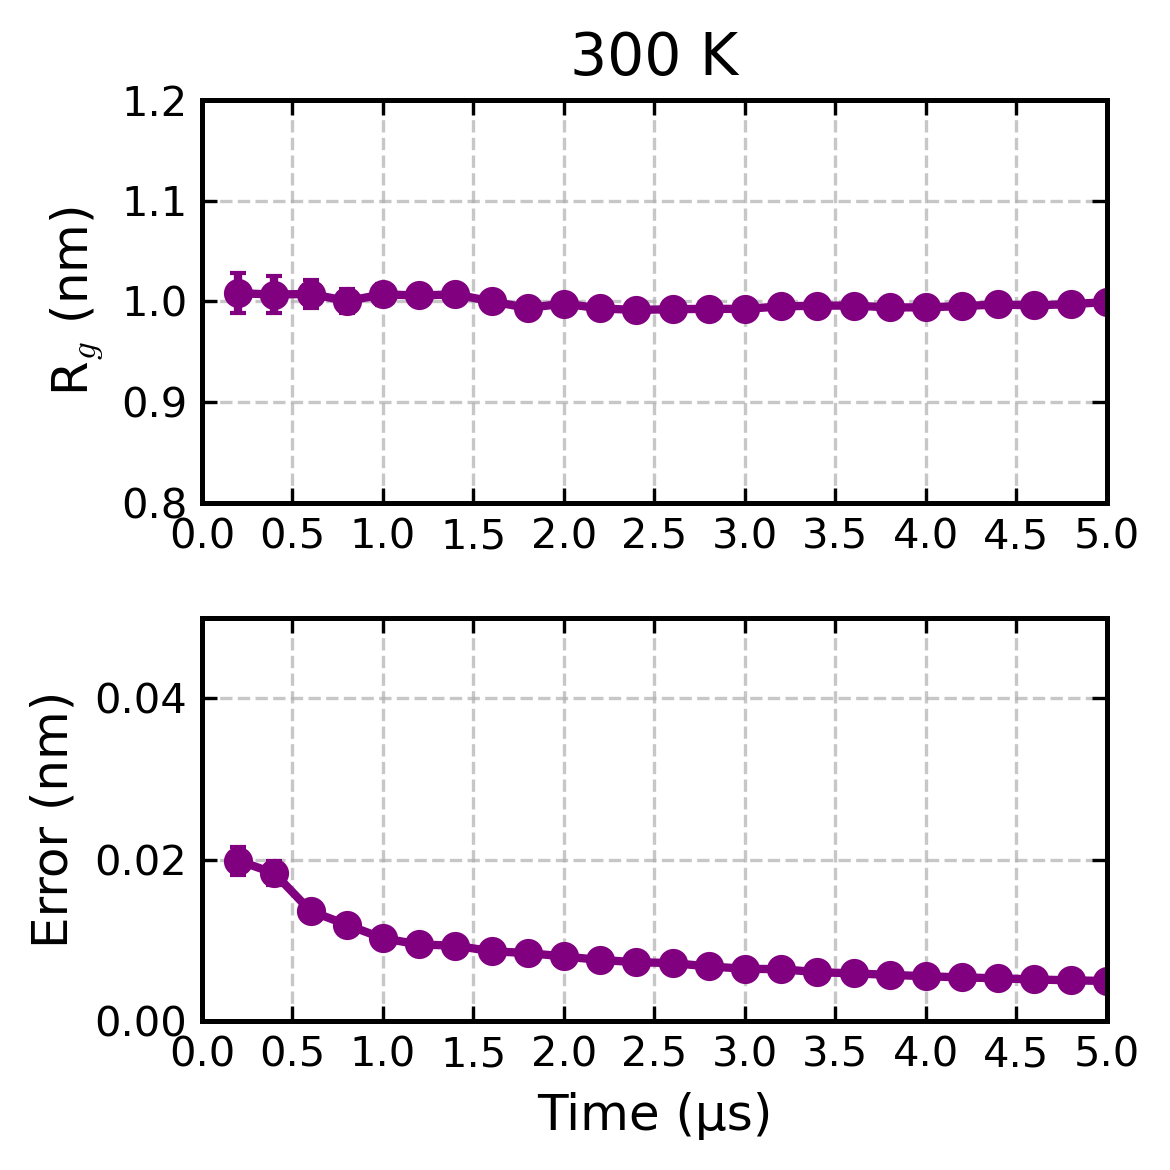

In [2]:
# Avg rg and std error of Rg as a function of sim time per replicate
# two plot panels: top shows the avg Rg as a function of time and bottom shows the std error as a function of time

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nsims = 3

times = np.arange(0.2, 5.2, 0.2) # times to check in μs

averages = []
errors = []
error_errors = []

for time in times:

    # load data and concatenate (and plot distributions of individual trajectories)
    for sim in range(nsims):
        if sim==0:
            data = read_colvar(path+f'COLVAR.{sim}')
            CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
            # Time arrays in μs
            time_data = data[:, 0] / 1e6        # ps -> μs
            # Apply cutoff at 5 µs
            mask_data = time_data <= time
            data = data[mask_data]
            CVS = CVS[mask_data]

        else:
            tmpdata = read_colvar(path+f'COLVAR.{sim}')
            tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
            # Time arrays in μs
            time_data = tmpdata[:, 0] / 1e6        # ps -> μs
            # Apply cutoff at 5 µs
            mask_data = time_data <= time
            tmpdata = tmpdata[mask_data]
            tmpCVS = tmpCVS[mask_data]
            data = np.concatenate((data, tmpdata), axis=0)
            CVS = np.concatenate((CVS, tmpCVS), axis=0)

    # rg of concatenated trajs
    rgdata = CVS[:,1]
    # weights
    bias = data[:,2]
    ene = data[:,1] # U
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    w = softmax(logw)
    w = w/np.sum(w)
    # remove frames with w=0
    mask = w != 0
    rgdata = rgdata[mask]
    weights_clean = w[mask]

    # append data
    averages.append(np.average(rgdata, weights=weights_clean, axis=0))
    reblocked = pyblock.blocking.reblock(rgdata, weights=weights_clean)  # default no weights
    opt = int(pyblock.blocking.find_optimal_block(len(rgdata), reblocked)[0])
    if opt==len(reblocked)-1:
        opt=opt-1
    stderr_bin = reblocked[opt].std_err
    errors.append(stderr_bin)
    error_errors.append( reblocked[opt].std_err_err)


# save results
df = pd.DataFrame()
df['Time (μs)'] = np.round(times, 3)
df['Rg (nm)'] = np.round(averages, 5)
df['±'] = np.round(errors, 5)
df['Err ±'] = np.round(error_errors, 5)
df.to_csv(output_path+f'{prod_name}_rg_vs_time_convergene_{T}K.csv')

# plot results
plt.figure(figsize = (4, 4))

plt.subplot(2,1,1)
plt.errorbar(times, averages, errors, fmt= 'o-', color ='purple', capsize = 2)
plt.xlim(0, 5)
plt.ylim(0.8, 1.2)
plt.ylabel('R$_g$ (nm)')
plt.title(f'{T} K')
plt.xticks(ticks=np.round(np.arange(0.0, 5.5, 0.5), 1), labels = np.round(np.arange(0.0, 5.5, 0.5), 1))

plt.subplot(2,1,2)
plt.errorbar(times, errors, error_errors, fmt= 'o-', color ='purple', capsize = 2)
plt.xlim(0, 5)
plt.ylim(0, 0.05)
plt.ylabel('Error (nm)')
plt.xlabel('Time (μs)')
plt.xticks(ticks=np.round(np.arange(0.0, 5.5, 0.5), 1), labels = np.round(np.arange(0.0, 5.5, 0.5), 1))

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_rg_vs_time_convergene_{T}K.pdf")

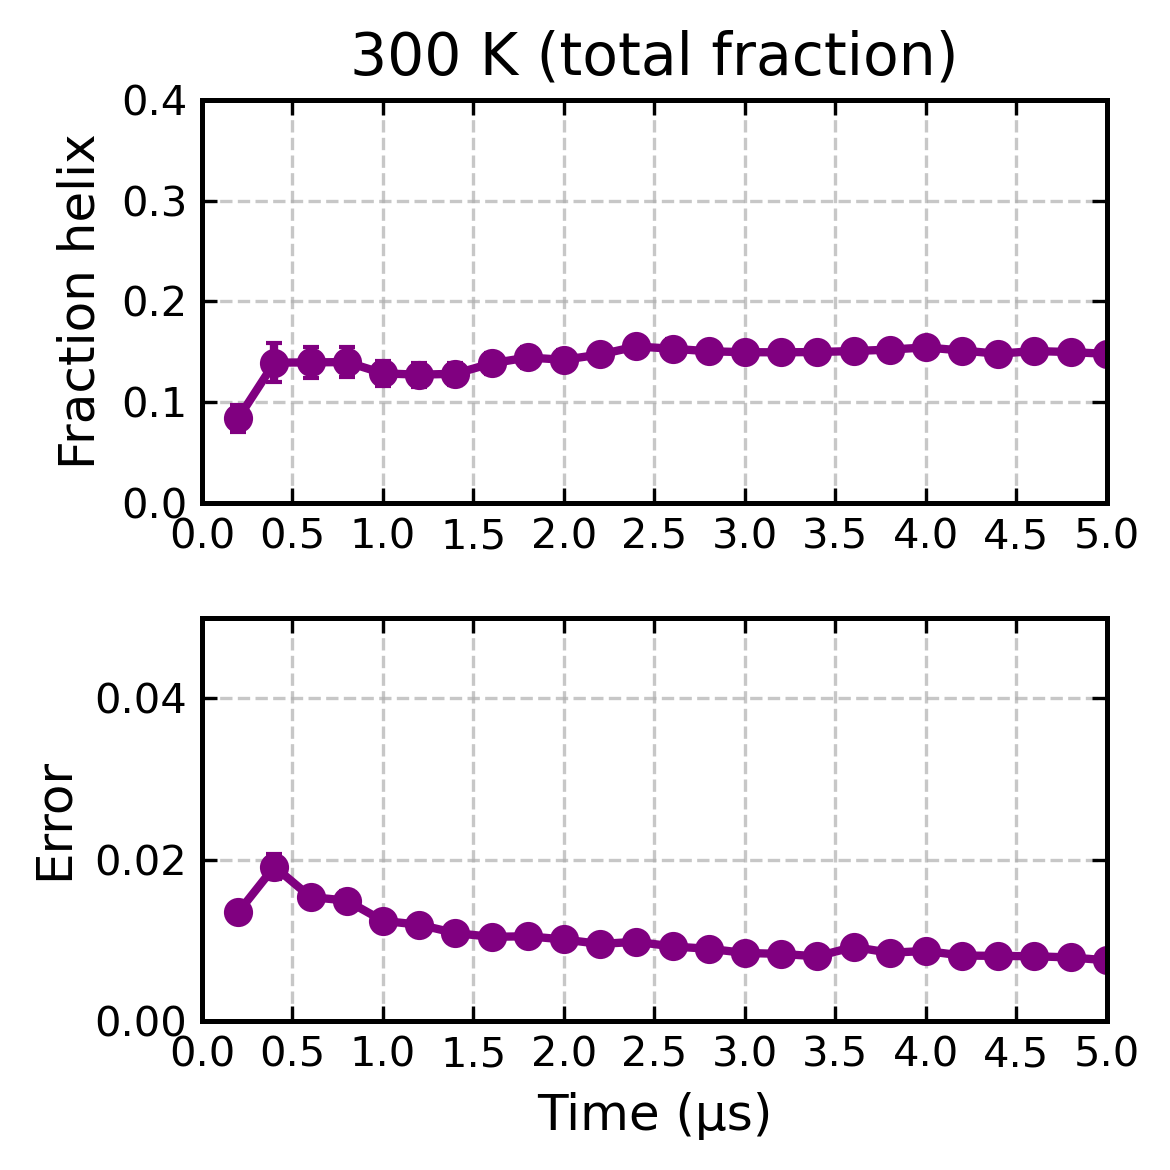

In [4]:
# time convergence of average  fraction helix of the ensemble (averaged )

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nsims = 3

times = np.arange(0.2, 5.2, 0.2) # times to check in μs

averages = []
errors = []
error_errors = []

for time in times:

    # load data and concatenate
    for sim in range(nsims):
        if sim==0:
            data = read_colvar(path+f'COLVAR.{sim}')
            with open(path+f'dssp{sim}.dat') as f:
                dssp = [line.strip() for line in f]
            # Time arrays in μs
            time_data = data[:, 0] / 1e6        # ps -> μs
            # Apply cutoff at 5 µs
            mask_data = time_data <= time
            data = data[mask_data]
            dssp =  np.array(dssp)[mask_data]
        else:
            tmpdata = read_colvar(path+f'COLVAR.{sim}')
            with open(path+f'dssp{sim}.dat') as f:
                tmpdssp = [line.strip() for line in f]
            # Time arrays in μs
            time_data = tmpdata[:, 0] / 1e6        # ps -> μs
            # Apply cutoff at 5 µs
            mask_data = time_data <= time
            tmpdata = tmpdata[mask_data]
            tmpdssp = np.array(tmpdssp)[mask_data]
            data = np.concatenate((data, tmpdata), axis=0)
            dssp = np.concatenate((dssp, tmpdssp), axis=0)

    # rg of concatenated trajs
    # Compute helical fraction for each frame
    helical_frac = np.array([helical_fraction(frame) for frame in dssp])
    # weights
    bias = data[:,2]
    ene = data[:,1] # U
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    w = softmax(logw)
    w = w/np.sum(w)
    # remove frames with w=0
    mask = w != 0
    helical_frac = helical_frac[mask]
    weights_clean = w[mask]

    # append data
    averages.append(np.average(helical_frac, weights=weights_clean, axis=0))
    reblocked = pyblock.blocking.reblock(helical_frac, weights=weights_clean)  # default no weights
    opt = int(pyblock.blocking.find_optimal_block(len(helical_frac), reblocked)[0])
    if opt==len(reblocked)-1:
        opt=opt-1
    stderr_bin = reblocked[opt].std_err
    errors.append(stderr_bin)
    error_errors.append( reblocked[opt].std_err_err)


# save results
df = pd.DataFrame()
df['Time (μs)'] = np.round(times, 3)
df['Fraction helix'] = np.round(averages, 5)
df['±'] = np.round(errors, 5)
df['Err ±'] = np.round(error_errors, 5)
df.to_csv(output_path+f'{prod_name}_HelicalFrac_vs_time_convergene_{T}K.csv')

# plot results
plt.figure(figsize = (4, 4))

plt.subplot(2,1,1)
plt.errorbar(times, averages, errors, fmt= 'o-', color ='purple', capsize = 2)
plt.xlim(0, 5)
plt.ylim(0., 0.4)
plt.ylabel('Fraction helix')
plt.title(f'{T} K (total fraction)')
plt.xticks(ticks=np.round(np.arange(0.0, 5.5, 0.5), 1), labels = np.round(np.arange(0.0, 5.5, 0.5), 1))

plt.subplot(2,1,2)
plt.errorbar(times, errors, error_errors, fmt= 'o-', color ='purple', capsize = 2)
plt.xlim(0, 5)
plt.ylim(0, 0.05)
plt.ylabel('Error')
plt.xlabel('Time (μs)')
plt.xticks(ticks=np.round(np.arange(0.0, 5.5, 0.5), 1), labels = np.round(np.arange(0.0, 5.5, 0.5), 1))

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_HelicalFrac_vs_time_convergene_{T}K.pdf")

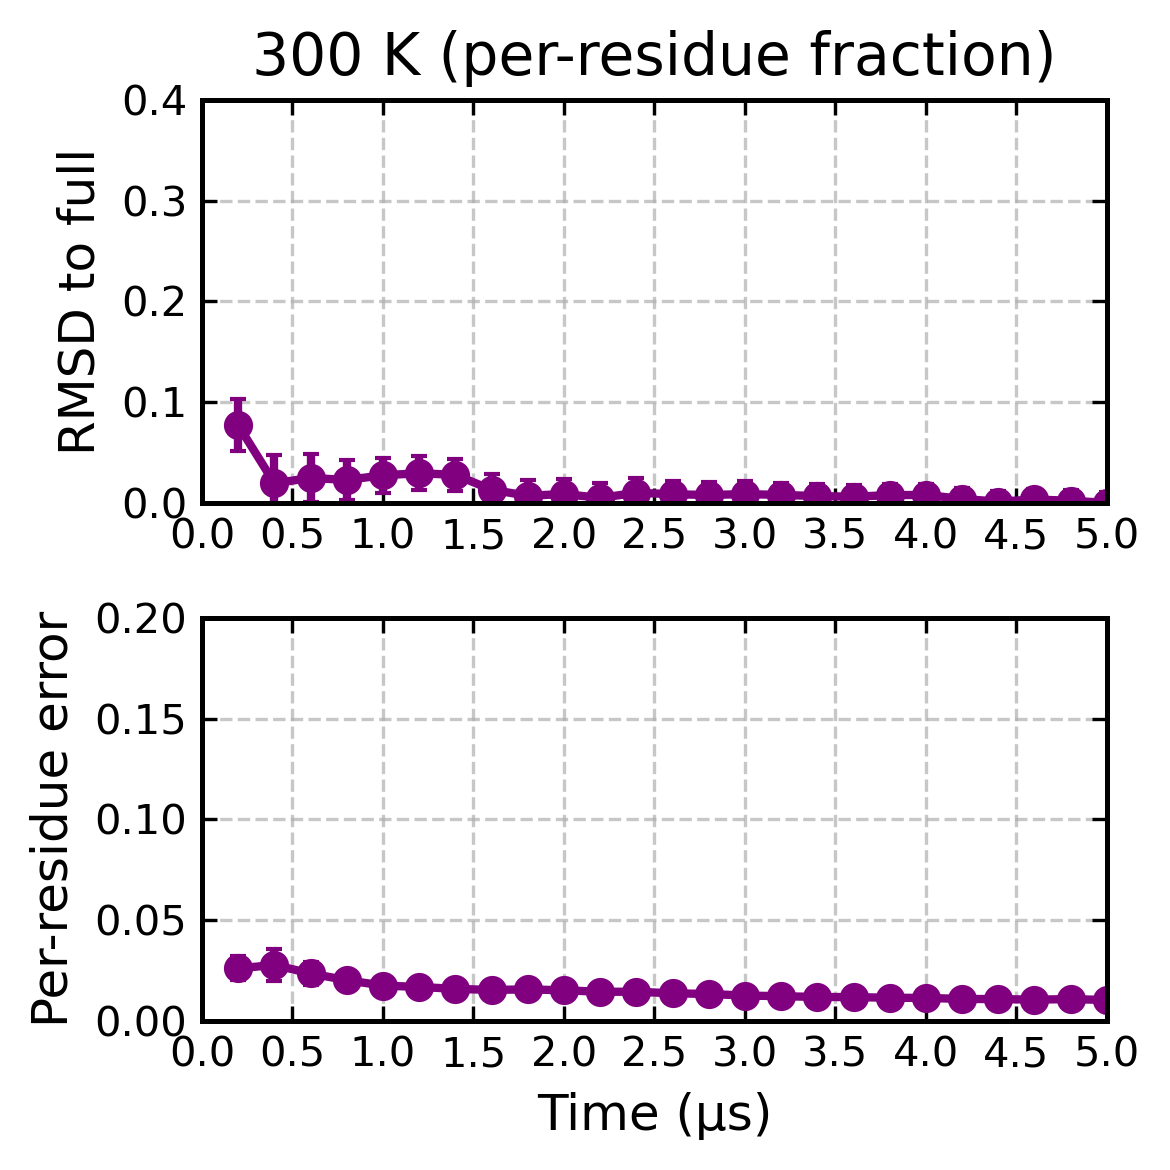

In [5]:
# time convergence of helicity profile across sequence (RMSD of per-residue fraction helix relative to final ensemble and average error of non-zero helicity residues)

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nsims = 3
residues = np.arange(1, 17+1)

times = np.arange(0.2, 5.2, 0.2) # times to check in μs

# reference helicity profile
ref = pd.read_csv(output_path+f"{prod_name}_perres_helicity_{T}K.csv")

averages = []
errors = []
error_errors = []

for time in times:

    # load data and concatenate
    for sim in range(nsims):
        if sim==0:
            data = read_colvar(path+f'COLVAR.{sim}')
            with open(path+f'dssp{sim}.dat') as f:
                dssp = [line.strip() for line in f]
            # Time arrays in μs
            time_data = data[:, 0] / 1e6        # ps -> μs
            # Apply cutoff at 5 µs
            mask_data = time_data <= time
            data = data[mask_data]
            dssp =  np.array(dssp)[mask_data]
        else:
            tmpdata = read_colvar(path+f'COLVAR.{sim}')
            with open(path+f'dssp{sim}.dat') as f:
                tmpdssp = [line.strip() for line in f]
            # Time arrays in μs
            time_data = tmpdata[:, 0] / 1e6        # ps -> μs
            # Apply cutoff at 5 µs
            mask_data = time_data <= time
            tmpdata = tmpdata[mask_data]
            tmpdssp = np.array(tmpdssp)[mask_data]
            data = np.concatenate((data, tmpdata), axis=0)
            dssp = np.concatenate((dssp, tmpdssp), axis=0)

    bias = data[:,2]
    ene = data[:,1] # U
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    w = softmax(logw)
    w = w/np.sum(w)
    # remove frames with w=0
    mask = w != 0
    weights_clean = w[mask]
    H = dssp_to_helicity(dssp[mask])
    avg_profile = np.average(H, weights=weights_clean, axis=0)
    rmsd = np.sqrt( np.mean( (avg_profile - np.array(ref['Fraction helix']) )**2 ))
    averages.append(rmsd)

    # error analysis
    n_frames, n_residues = H.shape
    stderr = np.zeros(n_residues)

    for j in range(n_residues):
        series = H[:, j]  # helicity time series for residue j
        if np.mean(series)==0:
            stderr[j] = float(0)
            continue
        reblock_data = pyblock.blocking.reblock(series, weights=weights_clean)
        optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
        if optimal==len(reblock_data)-1:
            optimal = optimal-1
        stderr[j] = reblock_data[optimal].std_err

    # average and standard deviation of per-residue errors (for non-zero fraction helix)
    avg_mask = avg_profile!=0
    errors.append(np.mean(stderr[avg_mask]))
    error_errors.append(np.std(stderr[avg_mask]))


# save results
df = pd.DataFrame()
df['Time (μs)'] = np.round(times, 3)
df['RMSD per-res helicity'] = np.round(averages, 5)
df['Avg. ±'] = np.round(errors, 5)
df['S.d. ±'] = np.round(error_errors, 5)
df.to_csv(output_path+f'{prod_name}_perres_helicity_vs_time_convergene_{T}K.csv')

# plot results
plt.figure(figsize = (4, 4))

plt.subplot(2,1,1)
plt.errorbar(times, averages, errors, fmt= 'o-', color ='purple', capsize = 2)
plt.xlim(0, 5)
plt.ylim(0., 0.4)
plt.ylabel('RMSD to full')
plt.title(f'{T} K (per-residue fraction)')
plt.xticks(ticks=np.round(np.arange(0.0, 5.5, 0.5), 1), labels = np.round(np.arange(0.0, 5.5, 0.5), 1))

plt.subplot(2,1,2)
plt.errorbar(times, errors, error_errors, fmt= 'o-', color ='purple', capsize = 2)
plt.xlim(0, 5)
plt.ylim(0, 0.2)
plt.ylabel('Per-residue error')
plt.xlabel('Time (μs)')
plt.xticks(ticks=np.round(np.arange(0.0, 5.5, 0.5), 1), labels = np.round(np.arange(0.0, 5.5, 0.5), 1))

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_helicity_vs_time_convergene_{T}K.pdf")